# EarlyDarkEmu

> GP emulator for power spectra in Early Dark Energy model

emulator for P(k) for dark matter power spectra

## Install

(not installable yet)
```sh
pip install EarlyDarkEmu
```

## Basic rundown

### A few imports 

In [ ]:
from EarlyDarkEmu.load import *
from EarlyDarkEmu.viz import *
from EarlyDarkEmu.pca import *
from EarlyDarkEmu.gp import *
from EarlyDarkEmu.emu import *
from EarlyDarkEmu.mcmc import *

import pandas as pd
import numpy as np
import matplotlib.pylab as plt


if_train_all = False ## Re-train all the models. Time-consuming. 
if_mcmc_all = False  ## Full MCMC run. Time-consuming. 
if_savefig = False

### Loading files

In [ ]:
Pk_all, k_all, z_all = load_npy_pk_k_z()
p_all = load_params()
print(p_all.shape, Pk_all.shape, k_all.shape, z_all.shape, PARAM_NAME)
print(len(PARAM_NAME))

remove_invalid_index = True
if remove_invalid_index == True:
    remove_sim_indx = [3]
    valid_indices = [i for i in  np.arange(Pk_all.shape[0])  if i not in remove_sim_indx]

    Pk_all = Pk_all[valid_indices]
    p_all = p_all[valid_indices]

(64, 7) (64, 51, 210) (210,) (51,) ['$\\Omega_m$', 'h', '$\\sigma_8$', '$\\log(z_c)$', '$f_{ede}$', '$\\theta_i$', '$\\Omega_{CDM}$']
7


### A few plotting routines

#### Experimental design

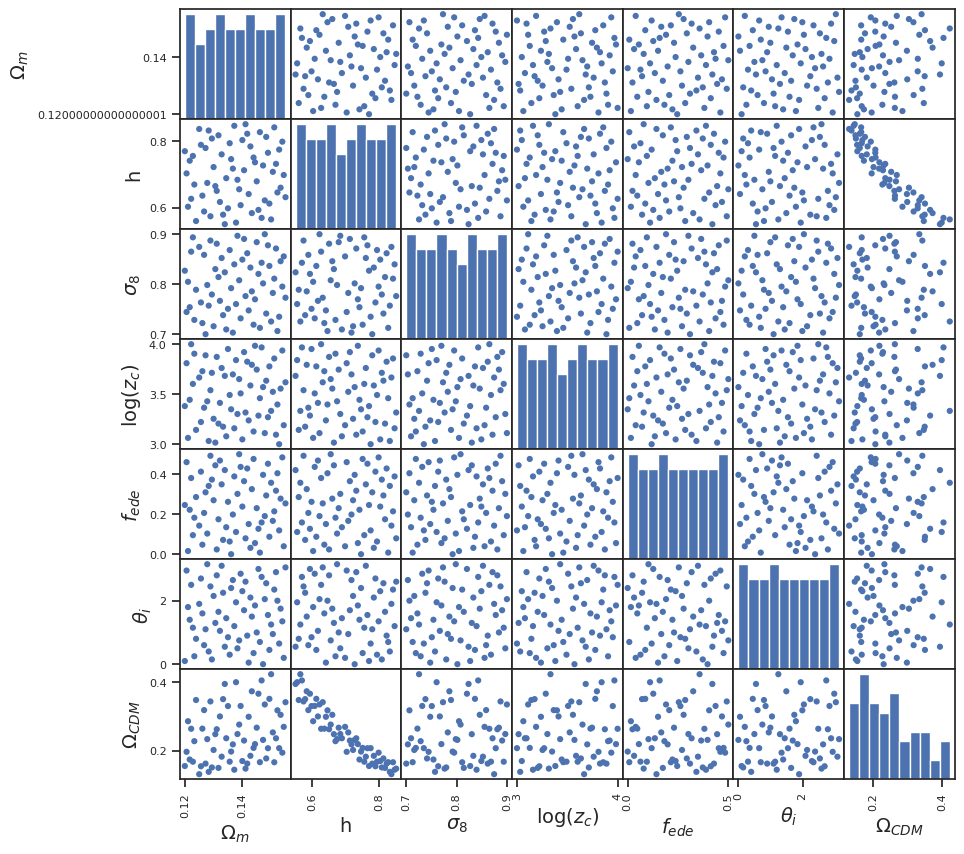

In [ ]:
df_train_a = pd.DataFrame(p_all, columns=PARAM_NAME)
colors = ['b']*p_all.shape[0]
# colors = ['b']*num_sims + ['r']*num_sims_test
plot_scatter_matrix(df_train_a, colors);



#### Boost metrics colored by cosmology parameters

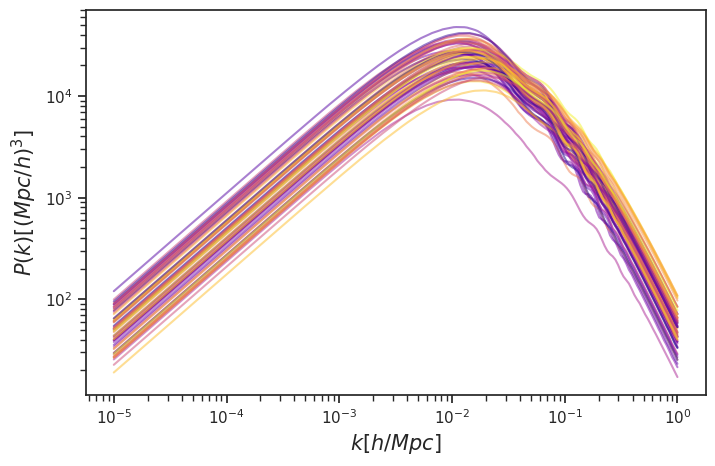

In [ ]:
color_by_index = 0
z_index = 0

plot_lines_with_param_color(p_all[:, color_by_index], 
                            k_all, 
                            Pk_all[:, z_index, :], 
                            'Training data, z=' + str(z_all[z_index]), 
                            r'$k [h/Mpc]$', 
                            r'$P(k) [(Mpc/h)^3]$', 
                            PARAM_NAME[color_by_index]);

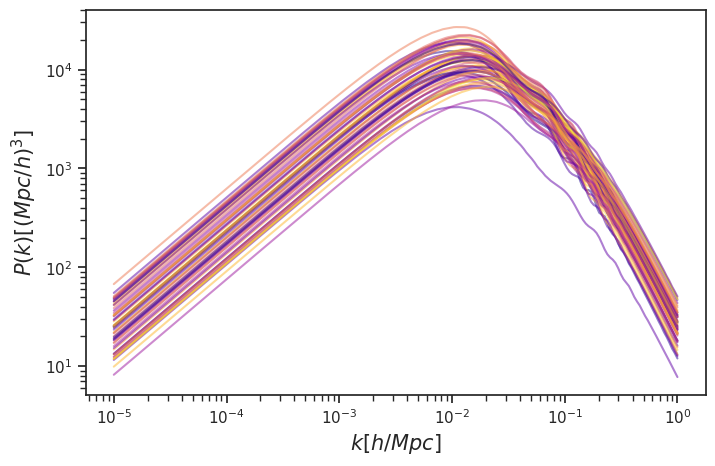

In [ ]:
#| hide 

color_by_index = 3
z_index = 21

plot_lines_with_param_color(p_all[:, color_by_index], 
                            k_all, 
                            Pk_all[:, z_index, :], 
                            'Training data, z=' + str(z_all[z_index]), 
                            r'$k [h/Mpc]$', 
                            r'$P(k) [(Mpc/h)^3]$', 
                            PARAM_NAME[color_by_index]);

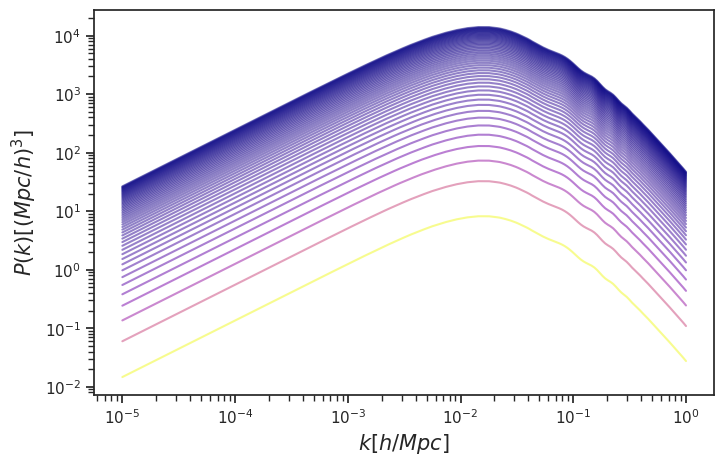

In [ ]:
#| hide 

z_index = 0

f = plot_lines_with_param_color(z_all, 
                            k_all, 
                            Pk_all[16, :, :], 
                            'Training data', 
                            r'$k [h/Mpc]$', 
                            r'$P(k) [(Mpc/h)^3]$', 
                            'redshift');

### Training involves: PCA, GP fitting.  

In [ ]:
## Data prep
z_index = 1
y_vals = Pk_all[:, z_index, :]
# y_ind = np.arange(0, y_vals.shape[1])
y_ind = k_all


# Train-test split
test_indices = [3, 14, 35]
input_params= p_all[test_indices]
target_vals = Pk_all[:, z_index, :][test_indices]

# Load validation data

# Bk_all_val, _, _ = load_boost_data(LIBRARY_BK_FILE_VAL, LIBRARY_ZK_FILE_VAL)
# target_vals = Bk_all_val[:, z_index, :]
# input_params = load_params(LIBRARY_PARAM_FILE_VAL)

train_indices = [i for i in  np.arange(Pk_all.shape[0]) if i not in test_indices]
p_all_train = p_all[train_indices]
y_vals_train = Pk_all[:, z_index, :][train_indices]
print('Redshift: ' + str(z_all[z_index]))

Redshift: 0.02


This SepiaData instance implies the following:
This is a simulator (eta)-only model, y dimension 210
m  =    60 (number of simulated data)
p  =     1 (number of inputs)
q  =     7 (number of additional simulation inputs)
pu NOT SET (transformed response dimension); call method create_K_basis 

Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
lamUz
[[5. 5.]]
lamWs
[[100. 100.]]
lamWOs
[[100.]]


Step size tuning: 100%|██████████| 50/50 [00:19<00:00,  2.52it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.75553679 0.25502087]
 [0.03126421 0.15718921]
 [0.28576794 0.18464261]
 [0.22184965 0.60391485]
 [0.154404   0.40586088]
 [0.1587034  0.6475692 ]
 [0.01047175 0.17358668]
 [0.24144343 0.76178557]]
lamUz
[[0.95066135 0.95031384]]
lamWs
[[ 890.85232642 4558.80911872]]
lamWOs
[[32.25130447]]


MCMC sampling: 100%|██████████| 1000/1000 [00:19<00:00, 52.53it/s]


Model saved to ../EarlyDarkEmu/model/multivariate_model_z_index1.pkl
No thetas to plot


(None, <Figure size 1000x750 with 5 Axes>)

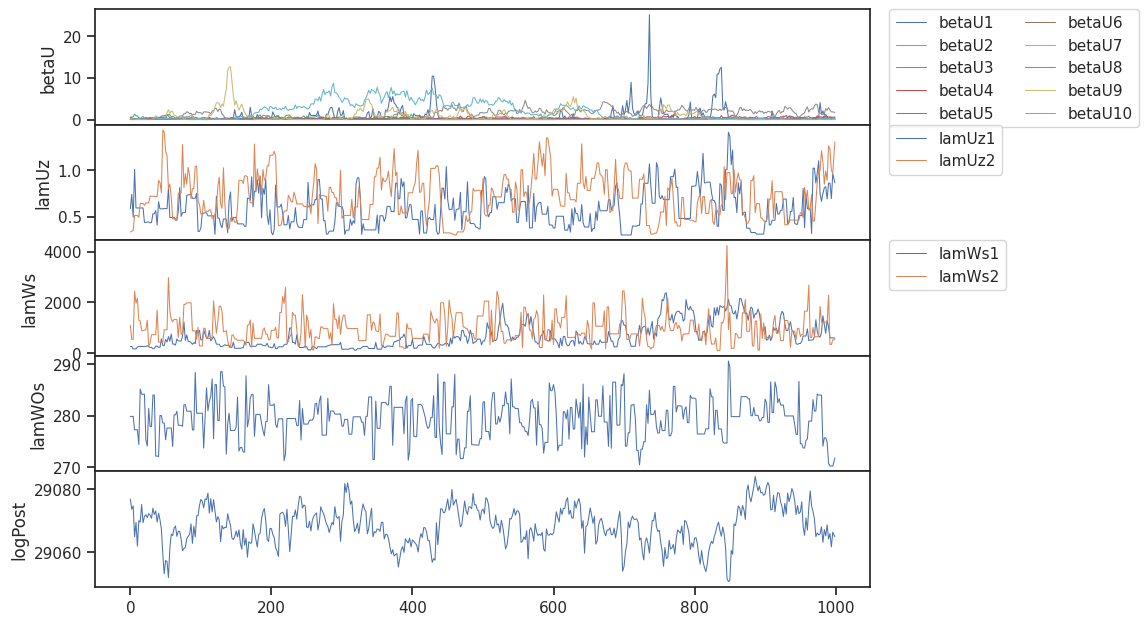

In [ ]:
sepia_data = sepia_data_format(p_all_train, y_vals_train, y_ind)
print(sepia_data)
model_filename = '../EarlyDarkEmu/model/multivariate_model_z_index' + str(z_index) 

sepia_model = do_pca(sepia_data, exp_variance=0.98)
sepia_model = do_gp_train(sepia_model, model_filename)
plot_train_diagnostics(sepia_model)

### Load existing model

In [ ]:
sepia_model = gp_load(sepia_model, model_filename)

### Single-redshift emulation for new cosmological parameters

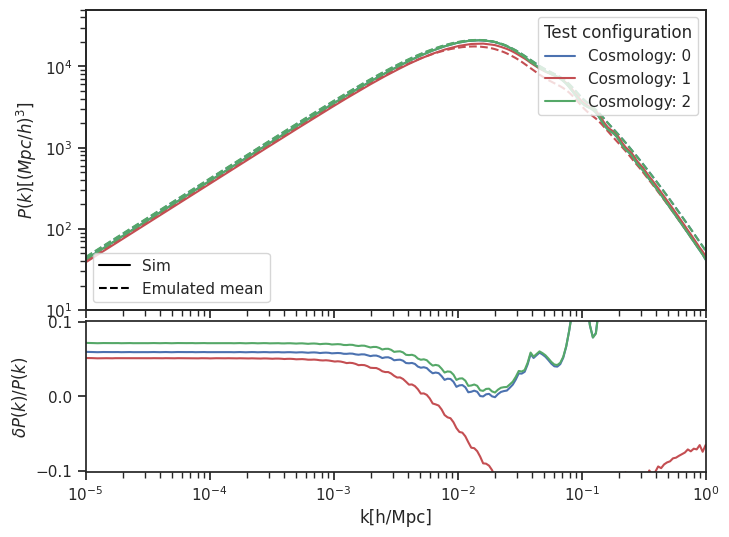

In [ ]:
test_indices_rand = np.random.randint(size=3, low=0, high=input_params.shape[0])
pred_mean, pred_quant = emulate(sepia_model, input_params[test_indices_rand])
# pred_quant == Emulated (0.05, 0.95) quantile
validation_plot(k_all, target_vals[test_indices_rand], pred_mean, pred_quant, xy_lims=[1e-5, 1e0, 10, 5e4]);

### Sensitivity analysis from the emulator 

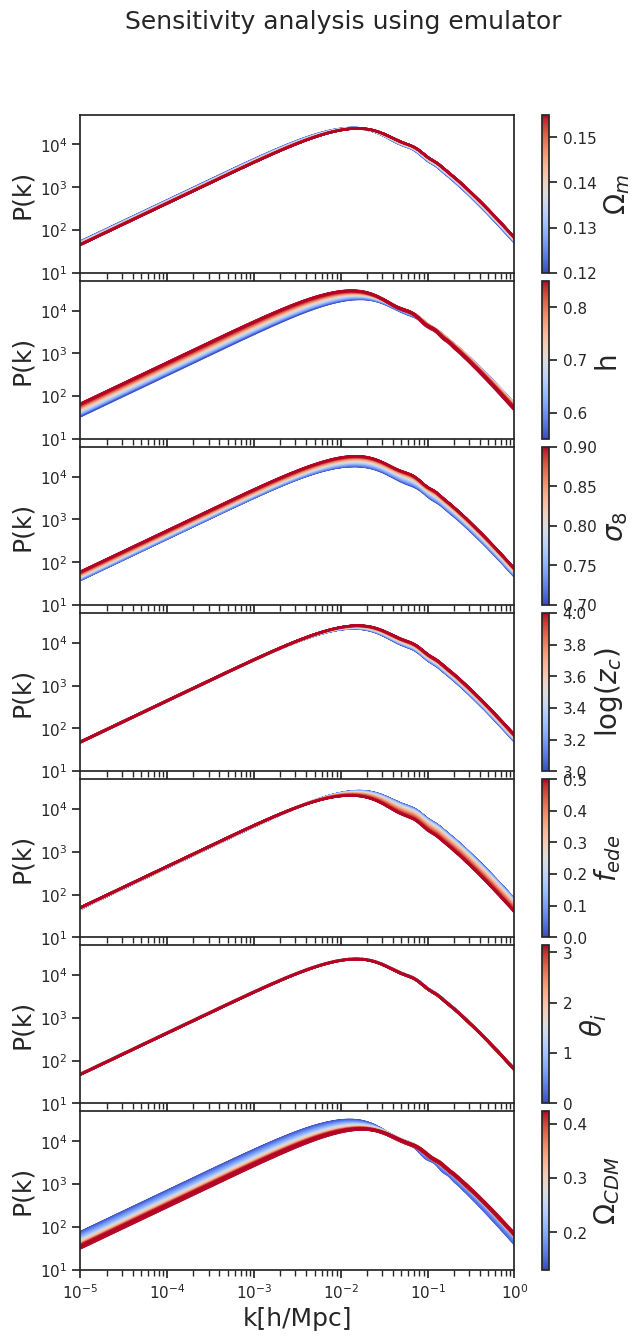

In [ ]:
f = sensitivity_plot(k_all, p_all, sepia_model, emulate, PARAM_NAME, xy_lims = [1e-5, 1e0, 10, 5e4] )

### Multi-redshift emulation

#### Train all the models

In [ ]:
if if_train_all:
    
    do_gp_train_multiple(model_dir='../EarlyDarkEmu/model/', 
                        p_train_all = p_all[train_indices],
                        y_vals_all = Pk_all[train_indices],
                        y_ind_all = k_all,
                        z_index_range=range(z_all.shape[0]))

#### Load all trained models 

In [ ]:
sepia_model_list = load_model_multiple(model_dir='../EarlyDarkEmu/model/', 
                                        p_train_all=p_all[train_indices],
                                        y_vals_all=Pk_all[train_indices],
                                        y_ind_all=k_all,
                                        z_index_range=range(z_all.shape[0]), 
                                        sepia_model_i=sepia_model)

In [ ]:
# #| hide

# #### Emulator uncertainty across parameter range


# input_params0 = input_params[0]
# z_inputs = 0.05
# input_params_and_redshift = np.append(input_params0, z_inputs)
# print(input_params_and_redshift[np.newaxis, :])


# emulated_with_redshift, emulated_with_redshift_err = emu_redshift(input_params_and_redshift[np.newaxis, :], sepia_model_list, z_all)
# ## There is an unknown issue with z_index=5 model, (sepia_model_list[6])
# emulate(sepia_model_list[6], input_params_and_redshift[:-1])[0]


# plt.figure(433)
# plt.plot(k_all, emulated_with_redshift[:, 0], label='interp at z=%.4f'%input_params_and_redshift[-1], lw=5, ls='--')
# plt.plot(k_all, emulate(sepia_model_list[0], input_params_and_redshift[:-1])[0], label='grid z=%.4f'%z_all[2])
# plt.plot(k_all, emulate(sepia_model_list[1], input_params_and_redshift[:-1])[0], label='grid z=%.4f'%z_all[3])
# plt.legend()
# plt.title('Comparison of redshift-space interpolation')
# # plt.plot(k_all, emulate(sepia_model_list[0], input_params))
# # plt.plot(k_all, emulate(sepia_model_list[0], input_params))

# plt.show()

#### Emulator confidence across parameter range

In [ ]:
# Parameter settings
steps = 40  # Number of steps in the grid for each parameter
param_name_extended = np.append(PARAM_NAME, 'Redshift')
red_min = 0
red_max = 3
red_mean = 1.0

param_min = np.append(p_all.min(axis=0), red_min)
param_max = np.append(p_all.max(axis=0), red_max)
param_mean = np.append(p_all.mean(axis=0), red_mean)

# Compute outputs and errors for a range of parameter values
def compute_errors(param_grid):
    print(param_grid.shape)
    errors = np.zeros(shape=(param_grid.shape[0], ))
    # errors = np.array([np.mean(emu_redshift(params[np.newaxis, :], sepia_model_list, z_all)[1][:, 0, :]**2) for params in param_grid])
    for par_indx in range(errors.shape[0]):

        errors[par_indx] = np.mean(emu_redshift(param_grid[par_indx][np.newaxis, :], sepia_model_list, z_all)[1][:, 0, :]**2)

    return errors.reshape(steps, steps)


# Example usage:
param_indices = [3, 4]  # Indices of parameters to vary
fixed_indices = [i for i in range(len(param_name_extended)) if i not in param_indices]
fixed_params = {param_name_extended[i]: param_mean[i] for i in fixed_indices}

param_grid = generate_param_grid_with_fixed(param_name_extended, param_indices, fixed_params, param_min, param_max, steps)

In [ ]:
errors = compute_errors(param_grid)

Number of models loaded: 51
(1600, 8)
redshift:  0.0408163
Burn-in phase
time (minutes): 0.010859131813049316
mcmc results: 0.12006745081113979 0.7690135159724223 0.8269984785699993 3.3808474199563525 0.24597003068069107 0.09953330075617212 0.1550107144447997


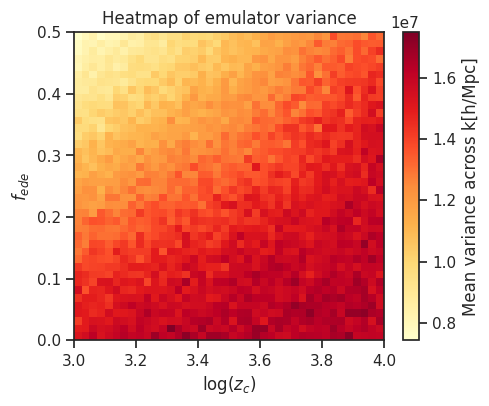

In [ ]:
f = plot_error_heatmap(errors, [param_name_extended[i] for i in param_indices], [(param_min[param_indices[0]], param_max[param_indices[0]]), (param_min[param_indices[1]], param_max[param_indices[1]])])

if if_savefig: 
    f.savefig('../../../Plots/heatmap_params_4_5.png', bbox_inches='tight')

### Parameter inference via MCMC using the emulator

In [ ]:
#| hide 

ndim = 7
nwalkers = 100  # 500
nrun_burn = 300  # 300
nrun = 700  # 1000

#### Creating mock observational data

In [ ]:

target_indx = 0 #0 ,14, 35
z_index = 2
L = 32
fake_obs_data_index_every = 1

redshift = z_all[z_index]
x = k_all[::fake_obs_data_index_every]
y = Pk_all[:, z_index, :][target_indx][::fake_obs_data_index_every]
y = y + 1e1*np.random.normal(0.0, 1.0, size=y.shape)
yerr = np.sqrt( Pk_all[:, z_index, :][target_indx][::fake_obs_data_index_every]*(L**3))/((0.1*L)**3)

x_grid = k_all
params_calib = p_all[target_indx][:, np.newaxis].T
print('redshift: ', redshift)

<matplotlib.legend.Legend>

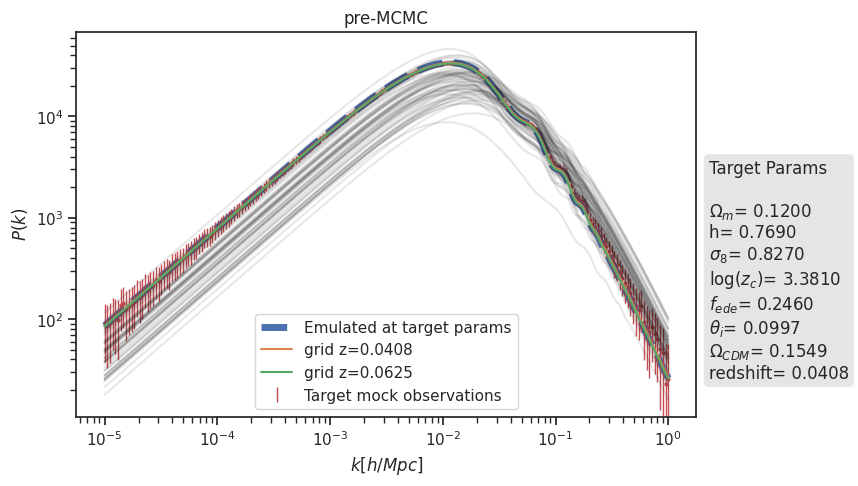

In [ ]:

f, a = plt.subplots(1,1, figsize = (8, 5)) 
input_params_and_redshift = np.append(params_calib, redshift)
bk_target, err_target = emu_redshift(input_params_and_redshift[np.newaxis, :], sepia_model_list, z_all)
a.plot(k_all, bk_target[:, 0], label='Emulated at target params', lw=5, ls='--')
a.errorbar(x, y, yerr, label='Target mock observations', ls='none', lw=1, color = "r")
a.scatter(x, y, s = 5, marker = "h", color = "r")


a.plot(k_all, Pk_all[:, z_index, :].T, 'k', alpha=0.1)


plt.plot(k_all, emulate(sepia_model_list[z_index], input_params_and_redshift[:-1])[0], label='grid z=%.4f'%z_all[z_index])
plt.plot(k_all, emulate(sepia_model_list[z_index+1], input_params_and_redshift[:-1])[0], label='grid z=%.4f'%z_all[z_index + 1])

string_print0 = 'Target Params \n\n' 
string_print1 = PARAM_NAME[0] + '= %.4f'%input_params_and_redshift[0] + '\n'
string_print2 = PARAM_NAME[1] + '= %.4f'%input_params_and_redshift[1] + '\n'
string_print3 = PARAM_NAME[2] + '= %.4f'%input_params_and_redshift[2] + '\n'
string_print4 = PARAM_NAME[3] + '= %.4f'%input_params_and_redshift[3] + '\n'
string_print5 = PARAM_NAME[4] + '= %.4f'%input_params_and_redshift[4] + '\n'
string_print6 = PARAM_NAME[5] + '= %.4f'%input_params_and_redshift[5] + '\n'
string_print7 = PARAM_NAME[6] + '= %.4f'%input_params_and_redshift[6] + '\n'
string_print8 = 'redshift' + '= %.4f'%input_params_and_redshift[7] 


string_print = string_print0 + string_print1 + string_print2 + string_print3 + string_print4 + string_print5 + string_print6 + string_print7 + string_print8

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
plt.text(1.02, 0.1, string_print, transform=a.transAxes, fontsize=12, bbox=props)


a.set_xscale('log')
a.set_yscale('log')
plt.title('pre-MCMC')
a.set_xlabel(r'$k [h/Mpc]$')
a.set_ylabel(r'$P(k)$')
plt.legend()

In [ ]:
#| hide 

allMax = np.max(p_all, axis = 0)
allMin = np.min(p_all, axis = 0)

param1 = [PARAM_NAME[0], params_calib[0][0], allMin[0], allMax[0]] 
param2 = [PARAM_NAME[1], params_calib[0][1], allMin[1], allMax[1]]
param3 = [PARAM_NAME[2], params_calib[0][2], allMin[2], allMax[2]]
param4 = [PARAM_NAME[3], params_calib[0][3], allMin[3], allMax[2]]
param5 = [PARAM_NAME[4], params_calib[0][4], allMin[4], allMax[4]]
param6 = [PARAM_NAME[5], params_calib[0][5], allMin[5], allMax[5]]
param7 = [PARAM_NAME[6], params_calib[0][6], allMin[6], allMax[6]]

params_list = [param1, param2, param3, param4, param5, param6, param7]

In [ ]:
pos0 = chain_init(params_list, ndim, nwalkers)
sampler = define_sampler(redshift, ndim, nwalkers, params_list, x_grid, sepia_model_list, z_all, x, y, yerr)

##### MCMC run - first burn, then full. 


In [ ]:

pos, prob, state, samples, sampler, autocorr, index = do_mcmc(sampler, pos0, nrun_burn, ndim, if_burn=True)

if if_mcmc_all: # Full MCMC-run, will be slow
    pos, prob, state, samples, sampler, autocorr, index = do_mcmc(sampler, pos, nrun, ndim, if_burn=False)

p_mcmc = mcmc_results(samples)

# fig = plot_mcmc(samples, params_list, if_truth_know=True)
# if if_savefig: 
#     plt.savefig('../../../Plots/mcmc_plot.png', bbox_inches='tight')

/home/nramachandra/anaconda3/envs/qom_torch_tf/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 33%|███▎      | 100/300 [00:00<00:00, 486.74it/s]/home/nramachandra/anaconda3/envs/qom_torch_tf/lib/python3.9/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]
100%|██████████| 300/300 [00:00<00:00, 390.82it/s]


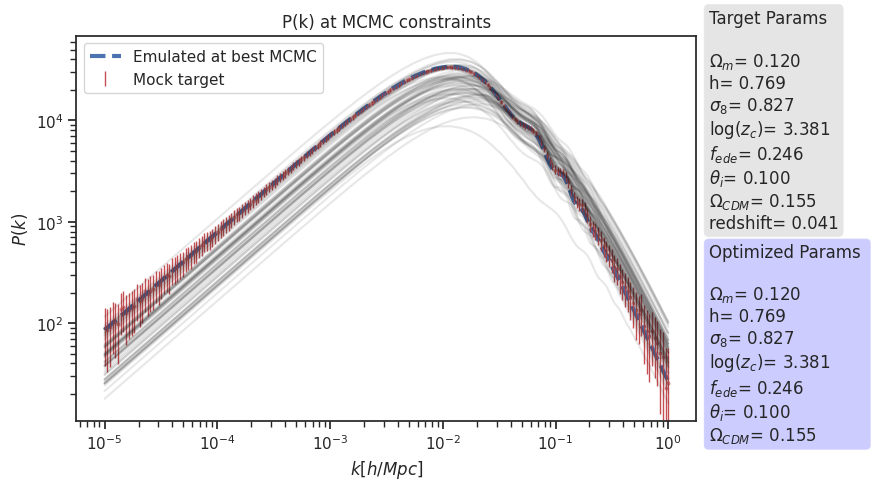

In [ ]:

f, a = plt.subplots(1,1, figsize = (8, 5)) 
input_params_and_redshift = np.append(p_mcmc, redshift)
bk_mcmc, err_mcmc = emu_redshift(input_params_and_redshift[np.newaxis, :], sepia_model_list, z_all)
a.plot(k_all, bk_mcmc[:, 0], label='Emulated at best MCMC', lw=3, ls='--')
a.errorbar(x, y, yerr, label='Mock target', ls='none', lw=1, color = "r")
a.scatter(x, y, s = 5, marker = "h", color = "r", alpha=0.5)

a.plot(k_all, Pk_all[:, z_index, :].T, 'k', alpha=0.1)


# plt.plot(k_all, emulate(sepia_model_list[z_index], input_params_and_redshift[:-1])[0], label='Z1')
# plt.plot(k_all, emulate(sepia_model_list[z_index+1], input_params_and_redshift[:-1])[0], label='Z2')

string_print0 = 'Target Params \n\n' 
string_print1 = PARAM_NAME[0] + '= %.3f'%params_calib[0][0] + '\n'
string_print2 = PARAM_NAME[1] + '= %.3f'%params_calib[0][1] + '\n'
string_print3 = PARAM_NAME[2] + '= %.3f'%params_calib[0][2] + '\n'
string_print4 = PARAM_NAME[3] + '= %.3f'%params_calib[0][3] + '\n'
string_print5 = PARAM_NAME[4] + '= %.3f'%params_calib[0][4] + '\n'
string_print6 = PARAM_NAME[5] + '= %.3f'%params_calib[0][5] + '\n'
string_print7 = PARAM_NAME[6] + '= %.3f'%params_calib[0][6] + '\n'
string_print8 = 'redshift' + '= %.3f'%redshift


string_print = string_print0 + string_print1 + string_print2 + string_print3 + string_print4 + string_print5 + string_print6 + string_print7 + string_print8

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
plt.text(1.02, 0.5, string_print, transform=a.transAxes, fontsize=12, bbox=props)

string_print0_mcmc = 'Optimized Params \n\n' 
string_print1_mcmc = PARAM_NAME[0] + '= %.3f'%p_mcmc[0] + '\n'
string_print2_mcmc = PARAM_NAME[1] + '= %.3f'%p_mcmc[1] + '\n'
string_print3_mcmc = PARAM_NAME[2] + '= %.3f'%p_mcmc[2] + '\n'
string_print4_mcmc = PARAM_NAME[3] + '= %.3f'%p_mcmc[3] + '\n'
string_print5_mcmc = PARAM_NAME[4] + '= %.3f'%p_mcmc[4] + '\n'
string_print6_mcmc = PARAM_NAME[5] + '= %.3f'%p_mcmc[5] + '\n'
string_print7_mcmc = PARAM_NAME[6] + '= %.3f'%p_mcmc[6] 

string_print_mcmc = string_print0_mcmc + string_print1_mcmc + string_print2_mcmc + string_print3_mcmc + string_print4_mcmc + string_print5_mcmc + string_print6_mcmc + string_print7_mcmc

props = dict(boxstyle='round', facecolor='blue', alpha=0.2)
plt.text(1.02, -0.05, string_print_mcmc, transform=a.transAxes, fontsize=12, bbox=props)



a.set_xscale('log')
a.set_yscale('log')
plt.title('P(k) at MCMC constraints')
a.set_xlabel(r'$k [h/Mpc]$')
a.set_ylabel(r'$P(k)$')
plt.legend()

if if_savefig: 
    plt.savefig('../../../Plots/mcmc_results_Bk.png', bbox_inches='tight')


In [ ]:
#| hide


if if_mcmc_all:
    tau = sampler.get_autocorr_time(tol=0)
    print(tau)

    plt.figure(43)
    plt.plot(prob)
    if if_savefig: 
        plt.savefig('../../../Plots/prob_plot.png', bbox_inches='tight')

    selected_indices_for_plot = [0, 2, 4]
    fig = plot_mcmc(samples[:, selected_indices_for_plot], [params_list[i] for i in selected_indices_for_plot], if_truth_know=True)

    if if_savefig: 
        plt.savefig('../../../Plots/mcmc_plot_reduced_params.png', bbox_inches='tight')

In [ ]:
#| hide


def plot_convergence(sampler, params_list, nrun, ndim, nwalkers):
    n_params = len(params_list)  # Number of parameters
    fig, ax = plt.subplots(n_params, 1, figsize=(20, 2 * n_params), sharex=True)
    ax[-1].set_xlabel('steps')

    for i, param in enumerate(params_list):
        ax[i].plot(np.arange(nrun), sampler.chain[:, :, i].T, lw=0.2, alpha=0.9)
        ax[i].text(0.9, 0.9, param[0], horizontalalignment='center', verticalalignment='center', transform=ax[i].transAxes, fontsize=12)

    # fig.savefig('plots/convergence_mcmc_ndim{}_nwalk{}_run{}_{}-{}.png'.format(ndim, nwalkers, nrun, summary_stat, design), dpi=100)

    return fig

if False:
    # Example usage
    plot_convergence(sampler, params_list, nrun, ndim, nwalkers)

In [ ]:
#| hide

if if_mcmc_all:

    n = 100 * np.arange(1, index + 1)
    y = autocorr[:index]
    plt.plot(n, n / 100.0, "--k")
    plt.plot(n, y)
    plt.xlim(0, n.max())
    plt.ylim(0, y.max() + 0.1 * (y.max() - y.min()))
    plt.xlabel("number of steps")
    plt.ylabel(r"mean $\hat{\tau}$");
    plt.show()

In [ ]:
#| hide

if if_mcmc_all:
    plt.plot(autocorr)
    plt.xscale('log')
    # plt.yscale('log')